<a href="https://colab.research.google.com/github/ErangaOttachchige/Final-Year-Research-Project/blob/main/00_cct20_dataset_setup_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1 — CCT20 setup + dataset analysis
This notebook does:
- Mount Drive and set paths
- Download/extract CCT20 only if missing
- Build `cct20_species_annotations.csv` only if missing
- Analyze class distribution and show sample images
- Build Stage 1 and Stage 2 CSVs for the next notebooks


In [6]:
# ✅ Run this after EVERY runtime restart (CPU↔GPU or disconnect)
from google.colab import drive
drive.mount("/content/drive")

import os, glob
DRIVE_CCT = "/content/drive/MyDrive/datasets/cct20"
IMG_DIR = f"{DRIVE_CCT}/eccv_18_all_images_sm"
ANN_DIR = f"{DRIVE_CCT}/eccv_18_annotation_files"
PROC_DIR = f"{DRIVE_CCT}/processed"
RAW_DIR  = f"{DRIVE_CCT}/raw"

os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(RAW_DIR, exist_ok=True)

print("Drive mounted ✅")
print("CCT20 exists:", os.path.exists(DRIVE_CCT))
print("Images folder exists:", os.path.exists(IMG_DIR))
print("Annotations folder exists:", os.path.exists(ANN_DIR))
print("Processed files:", os.listdir(PROC_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted ✅
CCT20 exists: True
Images folder exists: False
Annotations folder exists: False
Processed files: []


In [7]:
!pip -q install pandas numpy matplotlib scikit-learn pillow tqdm


In [8]:
import torch
print("CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA: False
GPU: None


In [9]:
# ✅ One-time download/extract (runs ONLY if missing)
import os, glob

img_tar = f"{RAW_DIR}/eccv_18_all_images_sm.tar.gz"
ann_tar = f"{RAW_DIR}/eccv_18_annotations.tar.gz"

# Download only if tar files missing
if not os.path.exists(img_tar):
    !wget -O "{img_tar}" https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/eccv_18_all_images_sm.tar.gz
else:
    print("✅ image tar exists (skip download)")

if not os.path.exists(ann_tar):
    !wget -O "{ann_tar}" https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/eccv_18_annotations.tar.gz
else:
    print("✅ annotation tar exists (skip download)")

# Extract only if folders missing or empty
def folder_has_files(p):
    return os.path.exists(p) and len(os.listdir(p)) > 0

if not folder_has_files(IMG_DIR):
    print("Extracting images...")
    !tar -xzf "{img_tar}" -C "{DRIVE_CCT}/"
else:
    print("✅ images already extracted (skip)")

if not folder_has_files(ANN_DIR):
    print("Extracting annotations...")
    !tar -xzf "{ann_tar}" -C "{DRIVE_CCT}/"
else:
    print("✅ annotations already extracted (skip)")

jpg1 = len(glob.glob(f"{IMG_DIR}/**/*.jpg", recursive=True))
jpg2 = len(glob.glob(f"{IMG_DIR}/**/*.JPG", recursive=True))
print("JPG count:", jpg1+jpg2)


--2026-02-02 22:40:04--  https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/eccv_18_all_images_sm.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.207, 142.251.183.207, 64.233.179.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6492615601 (6.0G) [application/x-tar]
Saving to: ‘/content/drive/MyDrive/datasets/cct20/raw/eccv_18_all_images_sm.tar.gz’

/content/drive/MyDr 100%[===================>]   6.05G  40.0MB/s    in 2m 52s  

2026-02-02 22:42:56 (36.1 MB/s) - ‘/content/drive/MyDrive/datasets/cct20/raw/eccv_18_all_images_sm.tar.gz’ saved [6492615601/6492615601]

--2026-02-02 22:42:56--  https://storage.googleapis.com/public-datasets-lila/caltechcameratraps/eccv_18_annotations.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 108.177.121.207, 209.85.145.207, ...
Connecting to storage.googleap

In [10]:
# ✅ Build annotation-level CSV (runs ONLY if missing)
import os
import json
from pathlib import Path
import pandas as pd

OUT_CSV = Path(PROC_DIR) / "cct20_species_annotations.csv"
if OUT_CSV.exists():
    print("✅ Exists:", OUT_CSV)
else:
    DRIVE_CCT_P = Path(DRIVE_CCT)
    IMG_ROOT = DRIVE_CCT_P / "eccv_18_all_images_sm"
    ANN_ROOT = DRIVE_CCT_P / "eccv_18_annotation_files"

    def is_coco_like(d):
        return isinstance(d, dict) and all(k in d for k in ["images","annotations","categories"])

    def resolve_image_path(file_name: str):
        p = IMG_ROOT / file_name
        if p.exists():
            return str(p)
        hits = list(IMG_ROOT.rglob(Path(file_name).name))
        return str(hits[0]) if hits else None

    rows = []
    for jp in sorted(ANN_ROOT.rglob("*.json")):
        with open(jp, "r", encoding="utf-8") as f:
            data = json.load(f)
        if not is_coco_like(data):
            continue

        cat_id_to_name = {c["id"]: str(c.get("name","")) for c in data["categories"]}
        cat_id_to_name_lower = {k:v.lower() for k,v in cat_id_to_name.items()}

        imgid_to_file = {}
        for im in data["images"]:
            fn = im.get("file_name") or im.get("filename")
            if fn is not None:
                imgid_to_file[im["id"]] = fn

        subset = jp.stem
        kept = 0
        for a in data["annotations"]:
            img_id = a["image_id"]
            cat_id = a["category_id"]
            fn = imgid_to_file.get(img_id)
            if not fn:
                continue
            path = resolve_image_path(fn)
            if not path:
                continue

            name = cat_id_to_name.get(cat_id, "unknown")
            is_empty = int(("empty" in cat_id_to_name_lower.get(cat_id,"")) or ("blank" in cat_id_to_name_lower.get(cat_id,"")))

            rows.append({
                "subset": subset,
                "image_id": img_id,
                "file_name": fn,
                "path": path,
                "category_id": cat_id,
                "category_name": name,
                "is_empty": is_empty,
                "bbox": tuple(a["bbox"]) if isinstance(a.get("bbox", None), list) else a.get("bbox", None),
            })
            kept += 1
        if kept > 0:
            print(f"[OK] {jp.name}: kept={kept}")

    df = pd.DataFrame(rows).drop_duplicates(subset=["subset","image_id","category_id","bbox"])
    df.to_csv(OUT_CSV, index=False)
    print("\n[SAVED]", OUT_CSV)
    print("Rows (annotations):", len(df), "| Unique images:", df["path"].nunique())


[OK] cis_test_annotations.json: kept=16395
[OK] cis_val_annotations.json: kept=3582
[OK] train_annotations.json: kept=14071
[OK] trans_test_annotations.json: kept=24028
[OK] trans_val_annotations.json: kept=1865

[SAVED] /content/drive/MyDrive/datasets/cct20/processed/cct20_species_annotations.csv
Rows (annotations): 59941 | Unique images: 57864


In [11]:
import pandas as pd, os, glob
df = pd.read_csv(f"{PROC_DIR}/cct20_species_annotations.csv")
print("Total annotations:", len(df))
print("Unique images:", df["path"].nunique())
print("\nTop subsets:\n", df["subset"].value_counts())
print("\nEmpty %:", round(df["is_empty"].mean()*100,2))
print("Empty count:", int(df["is_empty"].sum()))
print("Animal count:", int((df["is_empty"]==0).sum()))


Total annotations: 59941
Unique images: 57864

Top subsets:
 subset
trans_test_annotations    24028
cis_test_annotations      16395
train_annotations         14071
cis_val_annotations        3582
trans_val_annotations      1865
Name: count, dtype: int64

Empty %: 6.7
Empty count: 4014
Animal count: 55927


In [12]:
animals = df[df["is_empty"]==0].copy()
species_counts = animals["category_name"].value_counts()
print("Number of species:", len(species_counts))
print("\nSpecies counts:\n", species_counts)


Number of species: 15

Species counts:
 category_name
opossum     13755
raccoon      8259
rabbit       5756
coyote       5578
bobcat       5087
cat          4738
squirrel     3198
dog          3115
car          2613
bird         1897
skunk         863
rodent        818
deer          212
badger         30
fox             8
Name: count, dtype: int64


In [13]:
# missing path check
import os
missing = animals[~animals["path"].apply(os.path.exists)]
print("Missing animal paths:", len(missing))


Missing animal paths: 0


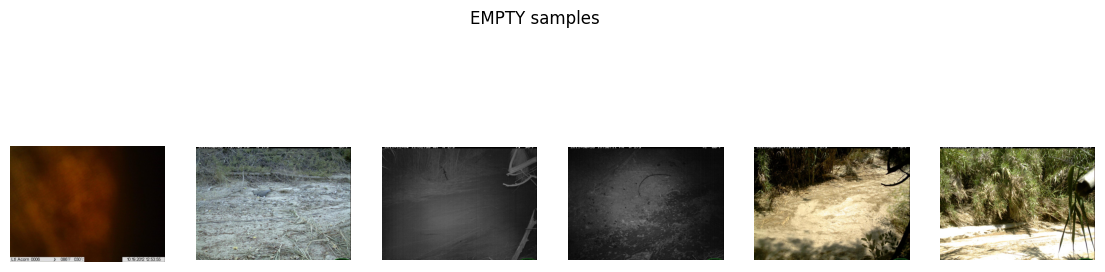

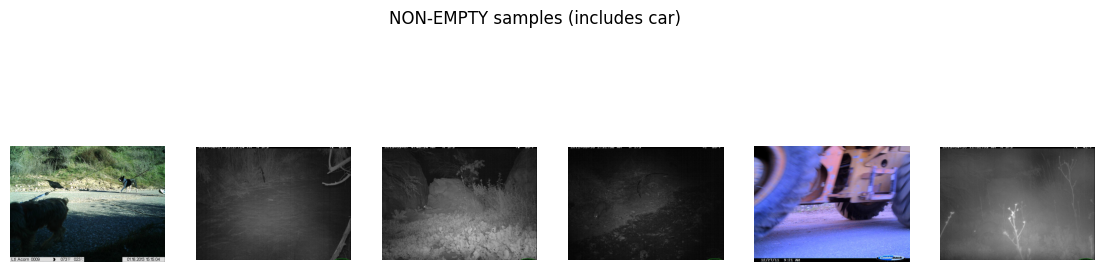

In [14]:
# sample images
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(df_in, title, n=6):
    samp = df_in.sample(n=min(n, len(df_in)), random_state=42)
    plt.figure(figsize=(14,4))
    for i, p in enumerate(samp["path"].tolist(), 1):
        img = Image.open(p).convert("RGB")
        plt.subplot(1, len(samp), i)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(df[df["is_empty"]==1], "EMPTY samples", n=6)
show_samples(animals, "NON-EMPTY samples (includes car)", n=6)


In [15]:
# ✅ Create Stage 1 + Stage 2 CSVs (runs ONLY if missing)
import os
import pandas as pd
from collections import Counter

SRC = f"{PROC_DIR}/cct20_species_annotations.csv"
df = pd.read_csv(SRC)

subset_to_split = {
    "train_annotations": "train",
    "cis_val_annotations": "val_cis",
    "trans_val_annotations": "val_trans",
    "cis_test_annotations": "test_cis",
    "trans_test_annotations": "test_trans",
}
df["split"] = df["subset"].map(subset_to_split).fillna("unknown")

# ---- Stage 1: empty / animal / car ----
out1 = f"{PROC_DIR}/cct20_stage1_imagelevel.csv"
if not os.path.exists(out1):
    def stage1_label(group):
        names = [str(x).lower() for x in group["category_name"].tolist()]
        if any("empty" in n or "blank" in n for n in names):
            return "empty"
        if any(n == "car" for n in names):
            return "car"
        return "animal"

    img_stage1 = (
        df.groupby(["subset","image_id","path","split"], as_index=False)
          .apply(lambda g: pd.Series({"label_stage1": stage1_label(g)}))
          .reset_index(drop=True)
    )
    img_stage1.to_csv(out1, index=False)
    print("Saved:", out1)
    print(img_stage1["label_stage1"].value_counts())
else:
    print("✅ Stage 1 exists:", out1)

# ---- Stage 2: 11 species + other (no empty, no car) ----
out2 = f"{PROC_DIR}/cct20_stage2_species_imagelevel.csv"
if not os.path.exists(out2):
    df2 = df[(df["is_empty"] == 0) & (df["category_name"].str.lower() != "car")].copy()

    def pick_label(group):
        names = group["category_name"].tolist()
        return Counter(names).most_common(1)[0][0]

    img_species = (
        df2.groupby(["subset","image_id","path","split"], as_index=False)
           .apply(lambda g: pd.Series({"label_name": pick_label(g)}))
           .reset_index(drop=True)
    )

    keep_species = ["opossum","raccoon","rabbit","coyote","bobcat","cat","squirrel","dog","bird","skunk","rodent"]
    img_species["label_lower"] = img_species["label_name"].str.lower()
    img_species["label_stage2"] = img_species["label_lower"].where(img_species["label_lower"].isin(keep_species), "other")

    img_species[["subset","image_id","path","split","label_stage2"]].to_csv(out2, index=False)
    print("Saved:", out2)
    print(img_species["label_stage2"].value_counts())
else:
    print("✅ Stage 2 exists:", out2)


/tmp/ipython-input-4053254575.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"label_stage1": stage1_label(g)}))


Saved: /content/drive/MyDrive/datasets/cct20/processed/cct20_stage1_imagelevel.csv
label_stage1
animal    51237
empty      4014
car        2613
Name: count, dtype: int64


/tmp/ipython-input-4053254575.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"label_name": pick_label(g)}))


Saved: /content/drive/MyDrive/datasets/cct20/processed/cct20_stage2_species_imagelevel.csv
label_stage2
opossum     13688
raccoon      7841
rabbit       5549
coyote       5315
bobcat       4961
cat          4601
squirrel     3181
dog          2788
bird         1402
skunk         857
rodent        812
other         242
Name: count, dtype: int64


✅ After this notebook, you should have in Drive `processed/`:
- `cct20_species_annotations.csv`
- `cct20_stage1_imagelevel.csv`
- `cct20_stage2_species_imagelevel.csv`
